ゼロつく第4章

In [12]:
import sys, os
import numpy as np
from sample.dataset.mnist import load_mnist

In [13]:
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)

print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000,)


In [14]:
# ミニバッチ学習

train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]
print(x_batch.shape)

(10, 784)


In [15]:
np.random.choice(60000, 10)

array([31240, 16969, 39483, 47387, 40361, 48118, 54796, 44154, 37075,
       44351])

In [16]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [17]:
def numerical_diff(f, x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

In [18]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

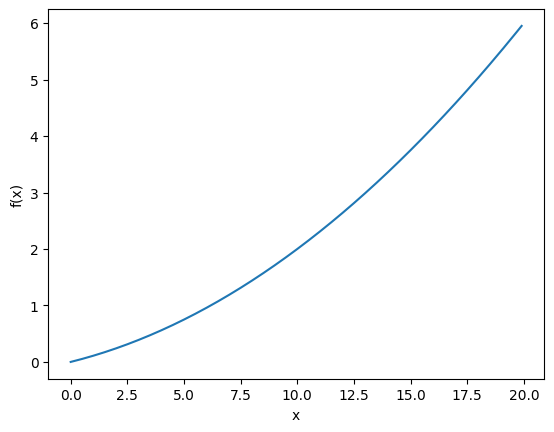

In [19]:
import matplotlib.pyplot as plt

x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

In [20]:
print(numerical_diff(function_1, 5))
print(numerical_diff(function_1, 10))

0.1999999999990898
0.2999999999986347


In [21]:
def function_2(x):
    return x[0]**2 + x[1]**2

In [22]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    # print(type(x))
    # print(x.shape)
    # print(f"x: {x}")

    # for idx in range(x.size):
    for idx in range(x.shape[0]):
        # print(idx)
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x)

        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
    
    return grad

In [23]:
print(numerical_gradient(function_2, np.array([3.0, 4.0])))
print(numerical_gradient(function_2, np.array([0.0, 2.0])))
print(numerical_gradient(function_2, np.array([3.0, 0.0])))

[6. 8.]
[0. 4.]
[6. 0.]


In [24]:
# 2層のニューラルネット
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [25]:
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

In [26]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        return y
    
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y==t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

In [27]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [28]:
from tqdm import tqdm

j = 0
for i in tqdm(range(10000)):
    j += i

100%|██████████| 10000/10000 [00:00<00:00, 5154607.35it/s]


In [29]:
# プロット
def plot_loss_acc(y):
    x = np.arange(len(y))
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_xlabel('iteration')
    # ax.set_ylabel('y')
    plt.show()

In [45]:
# テストデータ評価をしない

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

iters_num = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.2

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in tqdm(range(iters_num)):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.numerical_gradient(x_batch, t_batch)
    for key in ['W1', 'b1', 'W2', 'b2']:
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


In [46]:
train_loss_list

[6.907522368157678,
 6.90204180993975,
 6.899825233515321,
 6.907473068594018,
 6.9071868306028765,
 6.910487612984063,
 6.9052512178039684,
 6.908835500991339,
 6.906020097243303,
 6.90175819515794,
 6.906372227450747,
 6.908992211686224,
 6.907298250151972,
 6.907354067028597,
 6.908142548569238,
 6.905634765465436,
 6.9069428991500885,
 6.898356291875253,
 6.904562195718789,
 6.90192113369788]

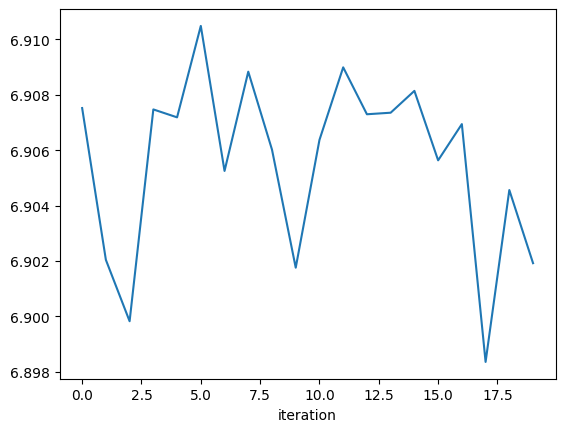

In [47]:
plot_loss_acc(train_loss_list)

In [32]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []
train_acc_list = []
test_acc_list = []

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

iter_per_epoch = max(train_size / batch_size, 1)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in tqdm(range(iters_num)):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch)
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train_acc, test_acc | " + str(train_acc) + "," + str(test_acc))

  1%|          | 58/10000 [00:00<00:54, 184.06it/s]

train_acc, test_acc | 0.11625,0.1221


  7%|▋         | 671/10000 [00:01<00:22, 408.49it/s]

train_acc, test_acc | 0.11236666666666667,0.1135


 13%|█▎        | 1306/10000 [00:03<00:31, 278.16it/s]

train_acc, test_acc | 0.11236666666666667,0.1135


 18%|█▊        | 1844/10000 [00:05<00:39, 206.27it/s]

train_acc, test_acc | 0.10441666666666667,0.1028


 24%|██▍       | 2389/10000 [00:07<00:20, 363.81it/s]

train_acc, test_acc | 0.11236666666666667,0.1135


 30%|███       | 3045/10000 [00:10<00:28, 243.41it/s]

train_acc, test_acc | 0.11236666666666667,0.1135


 37%|███▋      | 3667/10000 [00:11<00:15, 409.68it/s]

train_acc, test_acc | 0.11236666666666667,0.1135


 43%|████▎     | 4266/10000 [00:13<00:24, 237.73it/s]

train_acc, test_acc | 0.11236666666666667,0.1135


 49%|████▉     | 4876/10000 [00:15<00:13, 373.73it/s]

train_acc, test_acc | 0.11236666666666667,0.1135


 55%|█████▍    | 5475/10000 [00:16<00:13, 335.00it/s]

train_acc, test_acc | 0.11236666666666667,0.1135


 61%|██████    | 6062/10000 [00:18<00:14, 269.30it/s]

train_acc, test_acc | 0.11236666666666667,0.1135


 66%|██████▋   | 6639/10000 [00:20<00:14, 229.93it/s]

train_acc, test_acc | 0.11236666666666667,0.1135


 73%|███████▎  | 7256/10000 [00:21<00:08, 309.88it/s]

train_acc, test_acc | 0.11236666666666667,0.1135


 79%|███████▊  | 7868/10000 [00:23<00:07, 295.55it/s]

train_acc, test_acc | 0.11236666666666667,0.1135


 85%|████████▍ | 8486/10000 [00:25<00:05, 276.93it/s]

train_acc, test_acc | 0.11236666666666667,0.1135


 91%|█████████ | 9082/10000 [00:26<00:02, 370.39it/s]

train_acc, test_acc | 0.11236666666666667,0.1135


 97%|█████████▋| 9698/10000 [00:27<00:00, 382.58it/s]

train_acc, test_acc | 0.11236666666666667,0.1135


100%|██████████| 10000/10000 [00:28<00:00, 352.87it/s]
